# Oracle-MNIST Training



To run this you need to have the package 2dl installed: 
https://d2l.ai/chapter_installation/index.html


In [35]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
import torch.optim as optim


from utils import images_train, labels_train, images_test, labels_test

In [37]:
LR = 0.001 # Learning Rate
BATCH_SIZE_TRAINING = 256
BATCH_SIZE_VALIDATION = 36
NUM_EPOCHS = 10
TRAIN_VAL_SPLIT = 0.8

device = torch.device("cpu")

# LeNet

Read more about LeNet (LeCun et al 1998): https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

In [30]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        # nn.init.xavier_uniform_(module.weight)
        nn.init.normal_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
        
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [31]:
model = LeNet()

Input image shape:	 torch.Size([28, 28])
Input tensor shape:	 torch.Size([1, 28, 28])
Conv2d output shape:	 torch.Size([6, 28, 28])
Sigmoid output shape:	 torch.Size([6, 28, 28])
AvgPool2d output shape:	 torch.Size([6, 14, 14])
Conv2d output shape:	 torch.Size([16, 10, 10])
Sigmoid output shape:	 torch.Size([16, 10, 10])
AvgPool2d output shape:	 torch.Size([16, 5, 5])
Flatten output shape:	 torch.Size([16, 25])
Linear output shape:	 torch.Size([16, 120])
Sigmoid output shape:	 torch.Size([16, 120])
Linear output shape:	 torch.Size([16, 84])
Sigmoid output shape:	 torch.Size([16, 84])
Linear output shape:	 torch.Size([16, 10])


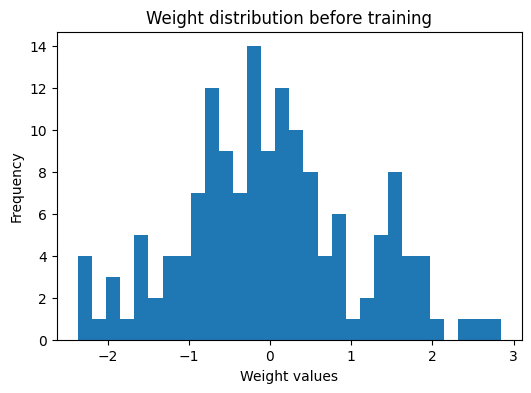

In [32]:
# Read one train image and check the layer output shapes
image_example = torch.from_numpy(images_train[0])
print('Input image shape:\t', image_example.size())

image_example = image_example.unsqueeze(0)  # Add batch dimension and the example
print('Input tensor shape:\t', image_example.size())

model.layer_summary(image_example.shape)

model.net.apply(init_cnn)

# plot the distribution of weights before training
plt.figure(figsize=(6, 4))
plt.hist(model.net[0].weight.data.numpy().flatten(), bins=30)
plt.title('Weight distribution before training')
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.show()

# Define a DataLoader class

In [33]:
image_train_tensor = torch.tensor(images_train)
label_train_tensor = torch.tensor(labels_train)
image_test_tensor = torch.tensor(images_test)
label_test_tensor = torch.tensor(labels_test)

# Split the training data into training and validation sets
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(image_train_tensor, label_train_tensor)
train_size = int(TRAIN_VAL_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE_TRAINING, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE_VALIDATION, shuffle=False)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

model.layer_summary((256, 1, 28, 28))

RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[1, 256, 28, 28] to have 1 channels, but got 256 channels instead

In [51]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    model.train()
    train_loss = 0
    print(f"Training on {len(trainloader)} batches")
    print(type(trainloader))
    for data_, label_ in trainloader:
        print(type(data_), data_.shape, type(label_), label_.shape)
        optimizer.zero_grad()
        data_ = data_.to(dtype=torch.float, device=device)
        outputs = model(data_)
        loss = criterion(outputs, label_.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # if SCHEDULER:
    #     scheduler.step()
    train_loss = train_loss / len(trainloader)
    train_loss_.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0
    print(f"Validating on {len(valloader)} batches")
    with torch.no_grad():
        for data_, label_ in valloader:
            data_ = data_.to(dtype=torch.float, device=device)
            outputs = model(data_)
            loss = criterion(outputs, label_.to(device))
            val_loss += loss.item()
    val_loss /= len(valloader)
    val_loss_.append(val_loss)
    
    # --- Logging ---
    if epoch%2 == 0:
        print(f"epoch : {epoch}/{NUM_EPOCHS}; Validation loss = {round(val_loss, 6)}; Training loss = {round(train_loss, 6)}")


Epoch 1/10
Training on 86 batches
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.Tensor'> torch.Size([256, 28, 28]) <class 'torch.Tensor'> torch.Size([256])


RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[1, 256, 28, 28] to have 1 channels, but got 256 channels instead